In [1]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2
import time
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from os.path import dirname, join
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os
from scipy.spatial.distance import euclidean
%matplotlib inline

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

In [3]:
prototxtPath = r"deploy.protext"
weightsPath = r"res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")

In [4]:
config_file='ssd_mobilenet_v3_large_coco_2020_01_14.pbtxt'
frozen_model='frozen_inference_graph.pb'
model=cv2.dnn_DetectionModel(frozen_model,config_file)
cL=[]
file_name='L.txt'
with open(file_name, 'rt') as fpt:
    cL=fpt.read().rstrip('\n').split('\n')
model.setInputSize(320,320)
model.setInputScale(1.0/127.5)
model.setInputMean((127.5,127.5,127.5))
model.setInputSwapRB(True)


<dnn_Model 000001B6727B63F0>

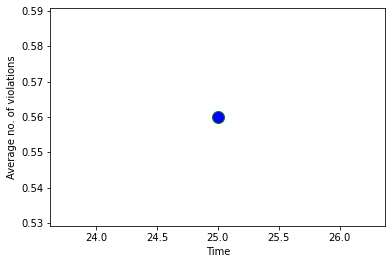

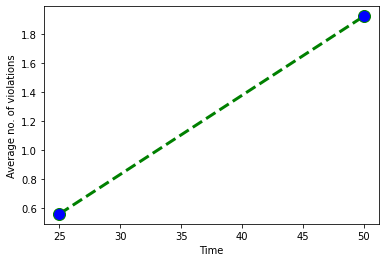

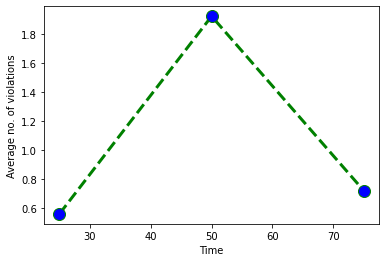

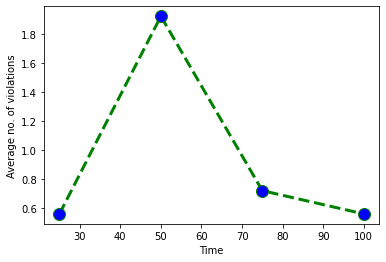

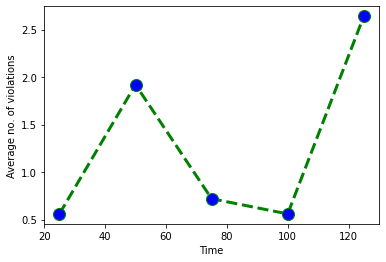

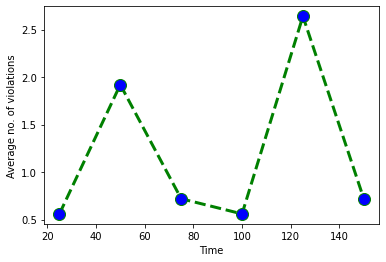

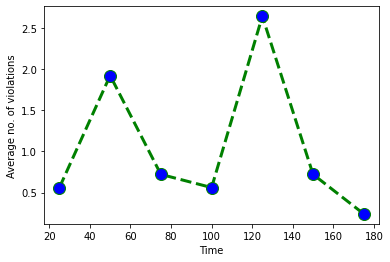

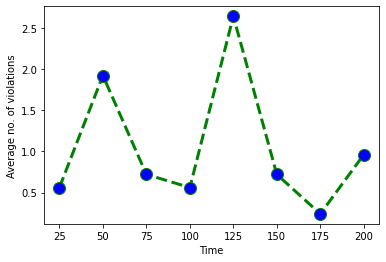

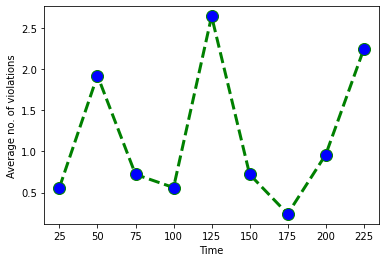

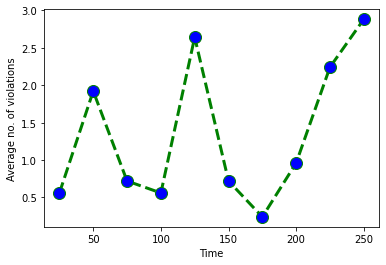

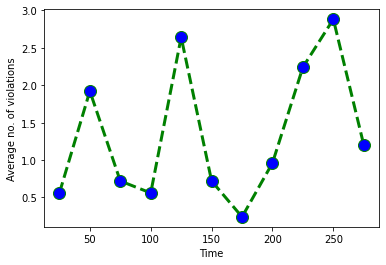

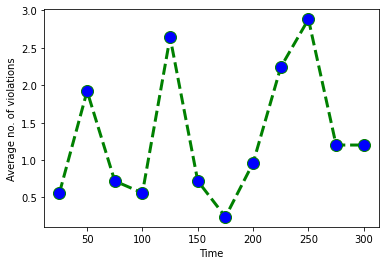

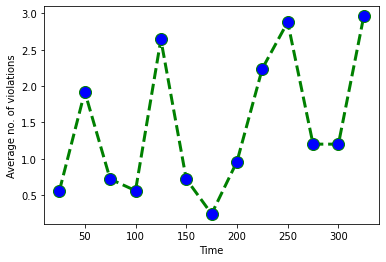

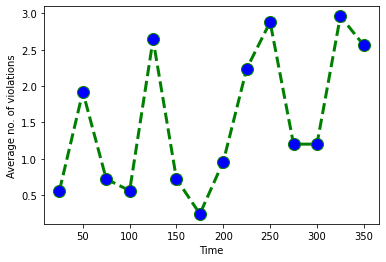

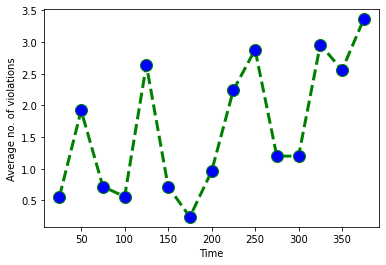

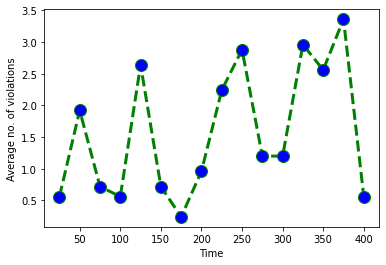

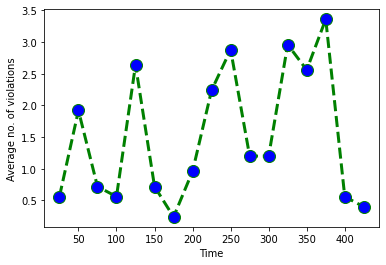

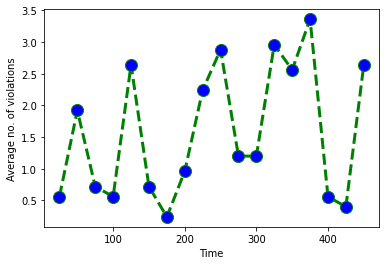

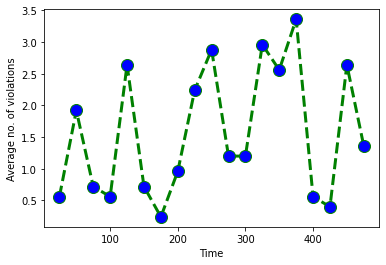

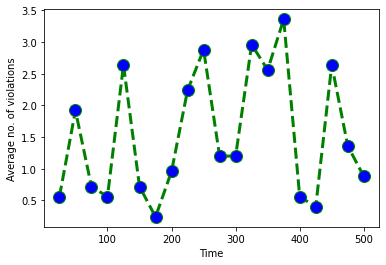

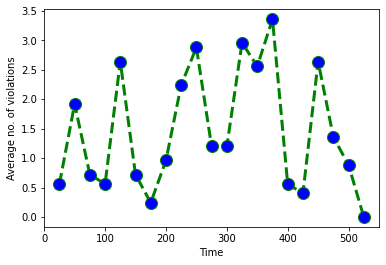

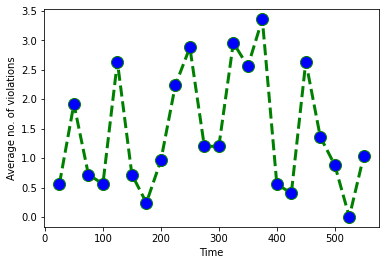

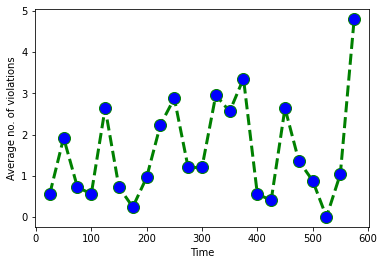

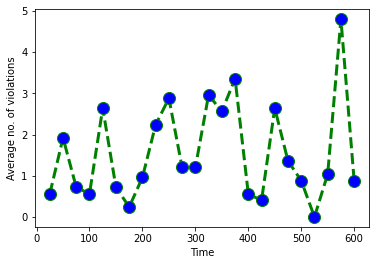

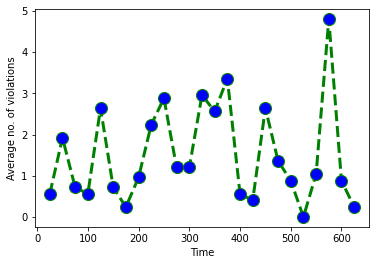

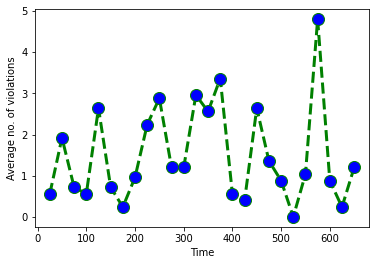

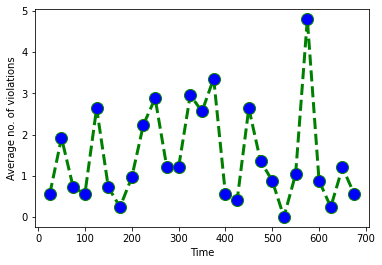

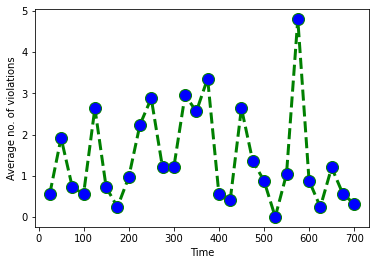

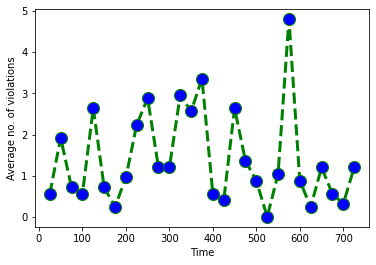

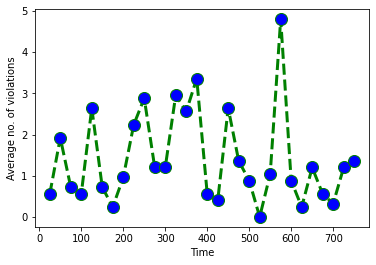

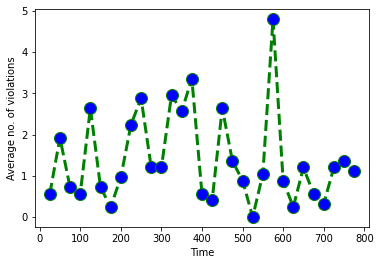

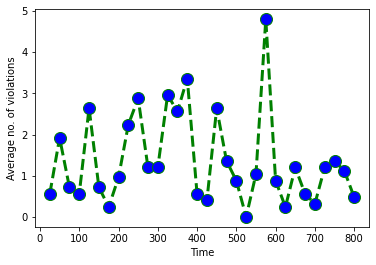

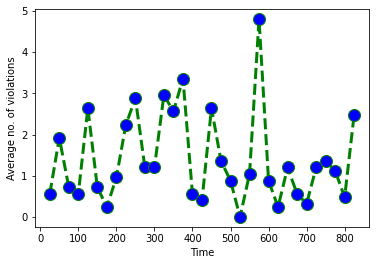

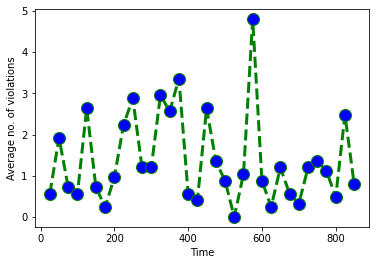

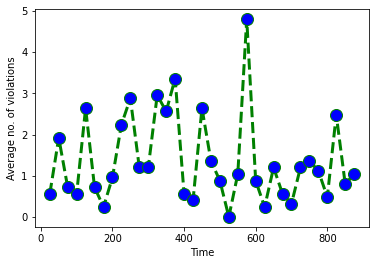

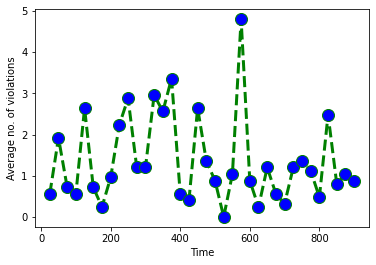

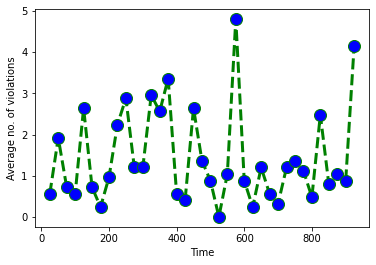

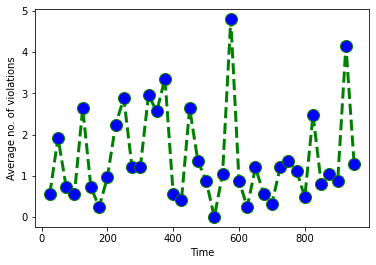

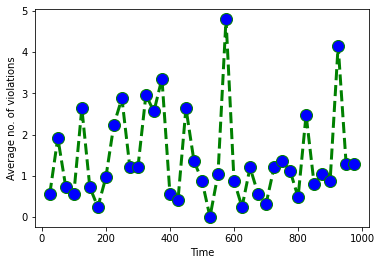

In [6]:
cap=cv2.VideoCapture('crowd_final_final.mp4')
import numpy as np
if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError('Cannot open video')

font_scale=1
font=cv2.FONT_HERSHEY_PLAIN

countf_1=1
x=[]
y=[]
while True:
    count=0
    ret,frame=cap.read()
    #frame1=frame
    
    ClassIndex,confidence,bbox=model.detect(frame,confThreshold=0.5)
    
    if(len(ClassIndex)!=0):
        arr=[]
        z=(0,0)
        q=(0,0)
        for ClassInd, conf, boxes in zip(ClassIndex.flatten(),confidence.flatten(),bbox):
            
            if(ClassInd==1):
#                 f=frame[boxes[1]-10:boxes[1]+boxes[3]+10,boxes[0]-10:boxes[0]+boxes[2]+10]
#                 detections = detector.detect_faces(f)
#                 for detection in detections:
#                     score = detection["confidence"]
#                     if score > 0.05:
#                         x, y, w, h = detection["box"]
#                         cv2.rectangle(frame, (boxes[0]+x-22, boxes[1]+y-22), (boxes[0]+x+w+12, boxes[1]+y+h+12), (0, 255, 0), 2)
#                         arr.append(((boxes[0]+x+boxes[0]+x+w)/2,(boxes[1]+y+boxes[1]+y+h)/2))
#                         cv2.imshow('Person Detected',frame)
                cv2.rectangle(frame,(boxes[0]-10,boxes[1]-10),(boxes[0]+boxes[2]+10,boxes[1]+boxes[3]+10),(255,0,0),2)
                arr.append(((boxes[0]+boxes[0]+boxes[2])/2,(boxes[1]+boxes[1]+boxes[3])/2))
                if(len(arr)>1):
                    closest_dst=float("inf")
                    for p in arr:
                        z=p
                        for c in arr:
                            if(c!=p):
                                q=c
                                if(euclidean(c, p)<120):
                                    if(countf_1%25==0):
                                        count+=1
                                    cv2.line(frame, (int(z[0]),int(z[1])), (int(q[0]),int(q[1])),(0,0,255), 2)
                                    
    if(countf_1%25==0):
        
        x.append(count/25)
        y.append(countf_1)
        plt.plot(y, x, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
        plt.xlabel('Time')
        plt.ylabel('Average no. of violations')
        plt.show()
    else:
        
        plt.close('all')
    
    countf_1+=1

                                   
                
                    
                
                
                
                
    frame = imutils.resize(frame, width=400)                
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    #----------------------------------------------------------------
    for (box, pred) in zip(locs, preds):
    # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    cv2.imshow('Person Detected',frame)
    
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()